In [1]:
import pandas as pd

In [22]:
df_train = pd.read_csv('data/project_mens_train_file.csv')
df_test = pd.read_csv('data/project_mens_test_file.csv')
df = df_train.append(df_test)

In [24]:
columns_list = df.columns
new_cols = [i.replace('.', '_') for i in columns_list]
df = df.rename(dict(zip(columns_list, new_cols)), axis=1)
df = df.drop(['train', 'id', 'gender'], axis=1)

# Preprocessing

In [25]:
# convert distance from sideline into actual x coordinates; required because they are measured as from single lines and baseline
df['x_coordinates_bounce'] = 4.125 - df['distance_from_sideline']
df['y_coordinates_bounce'] = 11.885 - df['depth']

In [26]:
# convert distance from sideline into actual x coordinates; required because they are measured as from single lines and baseline
df['x_coordinates_previous_bounce'] = 4.125 - df['previous_distance_from_sideline']
df['y_coordinates_previous_bounce'] = 11.885 - df['previous_depth']

# Feature Engineering

Difference of last shot speed and this shot speed; a combination of the interaction of the previous speed and this speed; although the model might be able to pick this up depending on the algorithm, this makes it explicit

In [27]:
df['speed_difference'] = df['speed'] - df['previous_speed']

It matters a lot where a shot bounces on the court; e.g. a bounce close to the side line might be better than one in the middle but very deep might 

In [28]:
df['bounce_impact_agg'] = df['x_coordinates_bounce'] * df['y_coordinates_bounce']
df['previous_bounce_agg'] = df['x_coordinates_previous_bounce'] * df['y_coordinates_previous_bounce']

In [29]:
df['player_last_shot_agg'] = df['player_impact_distance_from_center'] * df['player_impact_depth']

In [30]:
df['player_second_last_shot_agg'] = df['player_distance_from_center'] * df['player_depth']
df['opponent_second_last_shot_agg'] = df['opponent_distance_from_center'] * df['opponent_depth']

In [31]:
import utils

In [33]:
# map target class to something more meaningful
def map_outcome_to_binary_names(word):
    if word == 'UE':
        return 'is_unforced_error'
    if word == 'FE':
        return 'is_forced_error'
    if word == 'W':
        return 'is_winner'

# put mapping in label name variable
df['label_name'] = df['outcome'].apply(lambda x: map_outcome_to_binary_names(x))

### Quick eda for new features

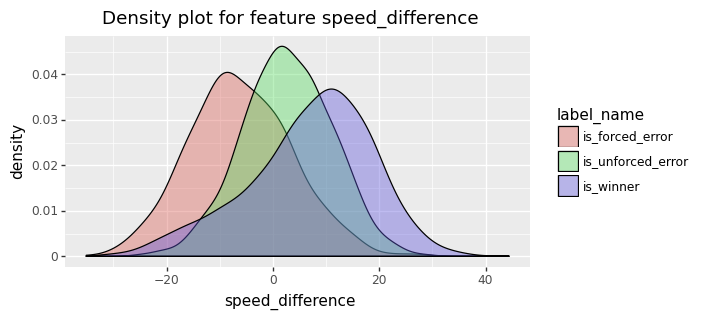

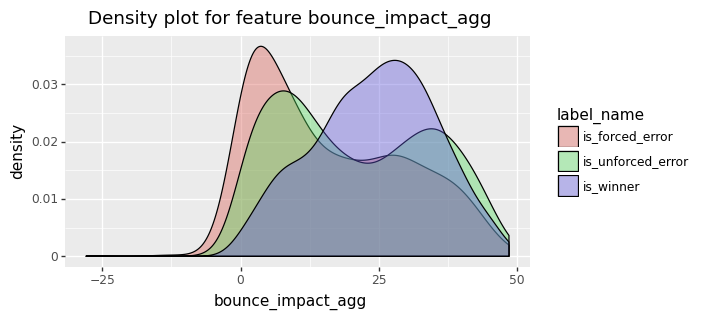

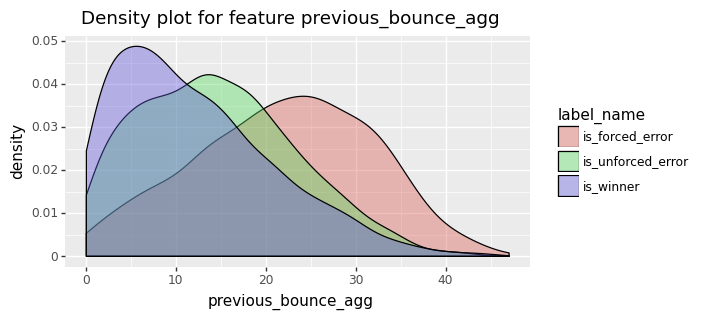

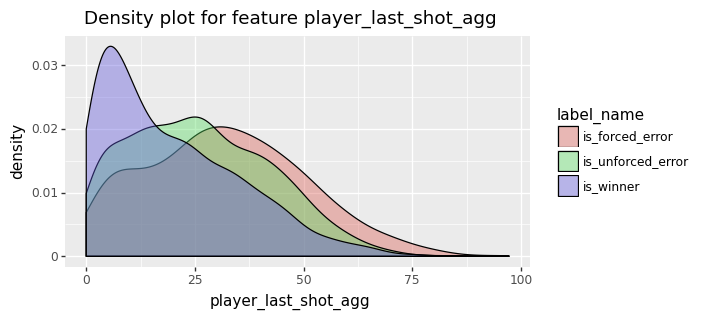

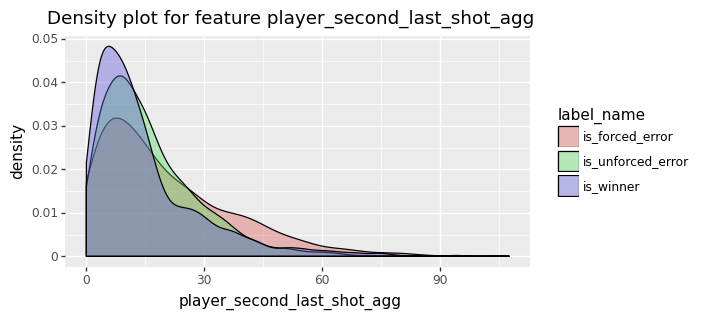

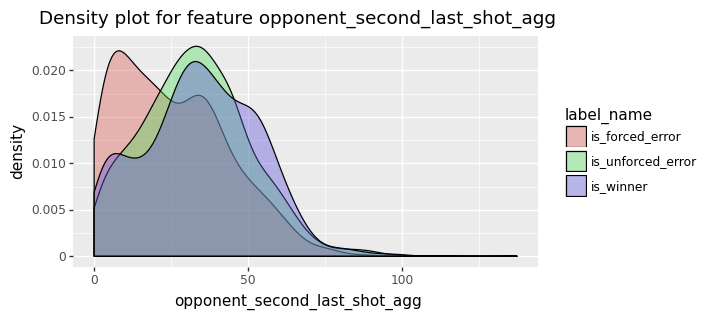

In [34]:
feature_engineered_features = ['speed_difference', 'bounce_impact_agg', 'previous_bounce_agg', 'player_last_shot_agg', 'player_second_last_shot_agg', 'opponent_second_last_shot_agg']
for feature in feature_engineered_features:
    gg = utils.plot_density_graph(df, feature)

Distance of bounce and player current position

In [35]:
import pandas as pd
from sklearn.linear_model import LogisticRegression 

In [36]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df_train = df[0:4000]
df_test = df[4000:]

In [50]:
df.columns.values

array(['rally', 'serve', 'hitpoint', 'speed', 'net_clearance',
       'distance_from_sideline', 'depth', 'outside_sideline',
       'outside_baseline', 'player_distance_travelled',
       'player_impact_depth', 'player_impact_distance_from_center',
       'player_depth', 'player_distance_from_center', 'previous_speed',
       'previous_net_clearance', 'previous_distance_from_sideline',
       'previous_depth', 'opponent_depth',
       'opponent_distance_from_center', 'same_side', 'previous_hitpoint',
       'previous_time_to_net', 'server_is_impact_player', 'outcome',
       'x_coordinates_bounce', 'y_coordinates_bounce',
       'x_coordinates_previous_bounce', 'y_coordinates_previous_bounce',
       'speed_difference', 'bounce_impact_agg', 'previous_bounce_agg',
       'player_last_shot_agg', 'player_second_last_shot_agg',
       'opponent_second_last_shot_agg', 'label_name'], dtype=object)

In [51]:
features = ['x_coordinates_bounce', 'y_coordinates_bounce',
       'x_coordinates_previous_bounce', 'y_coordinates_previous_bounce',
       'speed_difference', 'bounce_impact_agg', 'previous_bounce_agg',
       'player_last_shot_agg', 'player_second_last_shot_agg',
       'opponent_second_last_shot_agg']

In [52]:
X_train = df_train[features]
X_test = df_test[features]

In [41]:
y_train = df_train['outcome']
X_train = df_train.select_dtypes(exclude=['object'])

y_test = df_test['outcome']
X_test = df_test.select_dtypes(exclude=['object'])

Set up simple classifier

In [53]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predict for test set

In [54]:
y_preds = model.predict(X_test)
y_actual = y_test

Confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

labels = list(y_actual.unique())

array = confusion_matrix(y_actual, y_preds, labels=labels)

### Model evaluation

Confusion matrix

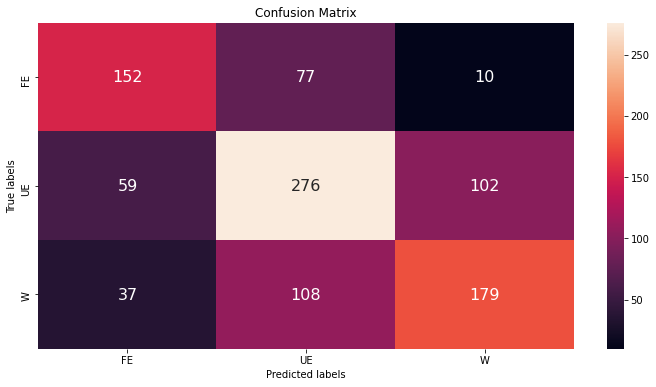

Accuracy score: 0.607
Precision score: 0.6089073274274543
Recall score: 0.6066771155897389
F1 score: 0.6070143774842943


In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(array, range(3), range(3))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))


sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax = ax, fmt='g') # font size

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

print('Accuracy score: {}'.format(accuracy_score(y_actual, y_preds)))
print('Precision score: {}'.format(precision_score(y_actual, y_preds, average='macro')))
print('Recall score: {}'.format(recall_score(y_actual, y_preds, average='macro')))
print('F1 score: {}'.format(f1_score(y_actual, y_preds, average='macro')))